# Read in the data

In [8]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [9]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [10]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [11]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [12]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [13]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [14]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [15]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [16]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [17]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## Introduction

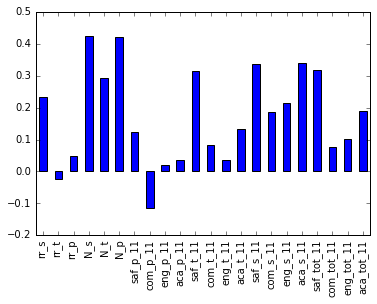

In [18]:
%matplotlib inline
combined.corr()['sat_score'].loc[survey_fields].plot.bar()

N_s, N_t, N_p and sat_score—the variables associated with total enrollment—are more strongly coorelated to SAT scores. 

aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Exploring Safety and SAT Scores

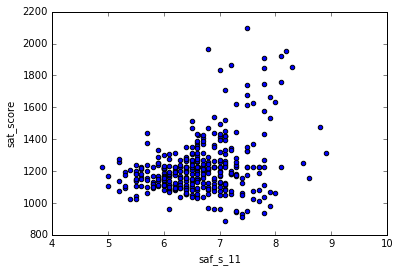

In [19]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

saf_s_11 and sat_score—the measure of how students perceive safety at school—seems positively coorelated with SAT scored.

In [20]:
safety_scores = combined.groupby('school_dist').agg(numpy.mean)
safety_scores.reset_index(inplace=True)
safety_scores.columns


Index(['school_dist', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Total Cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
       'SIZE OF LARGEST CLASS', 'SCHOOLWIDE PUPIL-TEACHER RATIO', 'schoolyear',
       'fl_percent', 'frl_percent', 'total_enrollment', 'ell_num',
       'ell_percent', 'sped_num', 'sped_percent', 'asian_num', 'asian_per',
       'black_num', 'black_per', 'hispanic_num', 'hispanic_per', 'white_num',
       'white_per', 'male_num', 'male_per', 'female_num', 'female_per', 'rr_s',
       'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11',
       'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11',
       'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11',
       'eng_tot_11', 'aca_tot_11

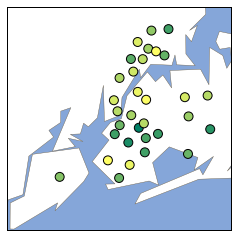

In [21]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = safety_scores['lon'].tolist()
latitudes = safety_scores['lat'].tolist()

m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, c=safety_scores['saf_s_11'], cmap='summer')

Central area seems to be rated the least safest by the students. THe upper coasal areas seem to be rated more safely.

## Exploring Race and SAT Scores

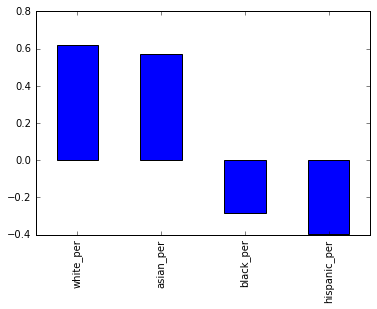

In [22]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'].loc[races].plot.bar()

White and Asian people disproportionately do better than black and hispanic students.

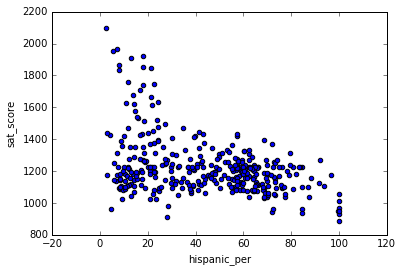

In [23]:
combined.plot.scatter('hispanic_per', 'sat_score')

Schools with large hispanic populations have lower SAT scores. While schools with very low hispanic populations have very high SAT scores.

In [24]:
is_high_hisp = combined['hispanic_per'] > 95
combined[is_high_hisp]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools found here with really high hispanic representation are marketed towards immigrants.

In [25]:
is_low_hisp = combined['hispanic_per'] < 10
combined[is_low_hisp]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

These are mostly selective private schools, some specializing in science. Apparently these schools are white af.

## Exploring Gender and SAT Scores

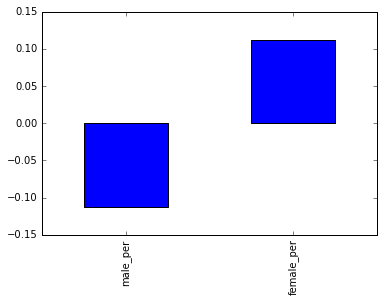

In [26]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

In genereal, schools with higher female representation do better on the SAT.

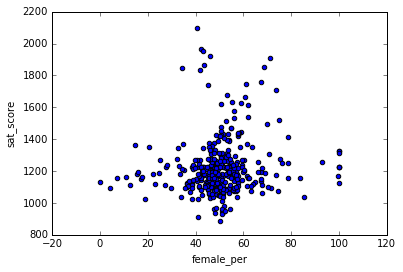

In [27]:
combined.plot.scatter('female_per', 'sat_score')

Actually based on the scatter plot it seems that schools that have more even representations of females and males have better SAT scores.

In [28]:
is_mostly_female = combined['female_per'] > 60
is_high_SAT = combined['sat_score'] > 1700

combined[is_mostly_female & is_high_SAT]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These are also selective schools—but more liberal art focused.

## Exploring AP Scores vs. SAT Scores

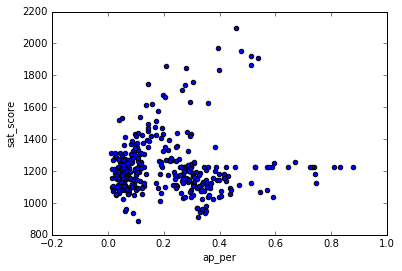

In [30]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')

There seems to be a divide—some schools show a st